In [1]:
nome = 'mateus oliveira'
print(f'Meu nome é {nome}')

Meu nome é mateus oliveira


#  Exercício: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício iremos treinar uma rede neural simples para prever a proxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Língua".

Este dataset já possui um tamanho razoável e é bem provável que você vai precisar rodar seus experimentos com GPU.

Alguns conselhos úteis:
- **ATENÇÃO:** o dataset é bem grande. Não dê comando de imprimí-lo.
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

In [2]:
# iremos utilizar a biblioteca dos transformers para ter acesso ao tokenizador do BERT.
!pip install transformers

     |████████████████████████████████| 4.2 MB 14.3 MB/s 
     |████████████████████████████████| 6.6 MB 48.2 MB/s 
     |████████████████████████████████| 596 kB 57.8 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Importação dos pacotes

In [3]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook


In [4]:
# Check which GPU we are using
!nvidia-smi

Wed May 18 23:02:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [6]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)

## Implementação do MyDataset

In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

from typing import List

def tokenize_timbau(text: str):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids


class MyDataset():
    def __init__(self, texts: List[str], tokenizer, context_size: int):
        self.texts = texts
        self.tokenizer = tokenizer
        self.context_size = context_size
        self.vocab = list(dict.fromkeys(" ".join(self.texts).split(' ')))# organize code
        self.count = 0
        self.tam = 0
        
        self.x = []
        self.y = []

        for idx, sentence in enumerate(self.texts):
            sentence_tokens = tokenize_timbau(sentence)
        
            for i, _ in enumerate(sentence_tokens):
                if i + context_size >= len(sentence_tokens):
                    break

                self.x.append(sentence_tokens[i:i+context_size])
                self.y.append(sentence_tokens[i+context_size])
        
        self.x, self.y = torch.LongTensor(self.x), torch.LongTensor(self.y)
        
        self.tam = self.x.shape[0]

    def __len__(self):
        return self.tam

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [8]:
tokenize_timbau('pizza')

[13779, 15616]

## Teste se sua implementação do MyDataset está correta

In [9]:

dummy_texts = ['Eu gosto de correr', 'Ela gosta muito de comer pizza']

dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, context_size=3)
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False)
assert len(dummy_dataset) == 5
print('passou no assert de tamanho do dataset')

first_batch_input, first_batch_target = next(iter(dummy_loader))

print(first_batch_input)

correct_first_batch_input = torch.LongTensor(
    [[ 3396, 10303,   125],
     [ 1660,  5971,   785],
     [ 5971,   785,   125],
     [  785,   125,  1847],
     [  125,  1847, 13779]])

correct_first_batch_target = torch.LongTensor([13239,   125,  1847, 13779, 15616])

assert torch.equal(first_batch_input, correct_first_batch_input)
print('Passou no assert de input')
assert torch.equal(first_batch_target, correct_first_batch_target)
print('Passou no assert de target')

passou no assert de tamanho do dataset
tensor([[ 3396, 10303,   125],
        [ 1660,  5971,   785],
        [ 5971,   785,   125],
        [  785,   125,  1847],
        [  125,  1847, 13779]])
Passou no assert de input
Passou no assert de target


In [10]:
first_batch_input

tensor([[ 3396, 10303,   125],
        [ 1660,  5971,   785],
        [ 5971,   785,   125],
        [  785,   125,  1847],
        [  125,  1847, 13779]])

In [11]:
first_batch_target

tensor([13239,   125,  1847, 13779, 15616])

# Carregamento do dataset 

Iremos usar uma pequena amostra do dataset [BrWaC](https://www.inf.ufrgs.br/pln/wiki/index.php?title=BrWaC) para treinar e avaliar nosso modelo de linguagem.

In [12]:
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula7/sample_brwac.txt

--2022-05-18 23:02:39--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula7/sample_brwac.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 173.194.69.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123983611 (118M) [text/plain]
Saving to: ‘sample_brwac.txt’

sample_brwac.txt    100%[===================>] 118.24M  96.4MB/s    in 1.2s    

2022-05-18 23:02:41 (96.4 MB/s) - ‘sample_brwac.txt’ saved [123983611/123983611]



In [13]:
# Load datasets
context_size = 9

valid_examples = 100
test_examples = 100
texts = open('sample_brwac.txt').readlines()

# print('Truncating for debugging purposes.')
# texts = texts[:500]  

training_texts = texts[:-(valid_examples + test_examples)]
valid_texts = texts[-(valid_examples + test_examples):-test_examples]
test_texts = texts[-test_examples:]

training_dataset = MyDataset(texts=training_texts, tokenizer=tokenizer, context_size=context_size)
valid_dataset = MyDataset(texts=valid_texts, tokenizer=tokenizer, context_size=context_size)
test_dataset = MyDataset(texts=test_texts, tokenizer=tokenizer, context_size=context_size)

In [14]:
print(f'training examples: {len(training_dataset)}')
print(f'valid examples: {len(valid_dataset)}')
print(f'test examples: {len(test_dataset)}')

training examples: 27675945
valid examples: 82070
test examples: 166726


In [15]:
import torch.nn.functional as F

class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, context_size, embedding_dim, hidden_size):
        """
        Implements the Neural Language Model proposed by Bengio et al."

        Args:
            vocab_size (int): Size of the input vocabulary.
            context_size (int): Size of the sequence to consider as context for prediction.
            embedding_dim (int): Dimension of the embedding layer for each word in the context.
            hidden_size (int): Size of the hidden layer.
        """
        super(LanguageModel, self).__init__()

        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, hidden_size)
        
        self.linear2 = nn.Linear(hidden_size, vocab_size, bias = False)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        """
        Args:
            inputs is a LongTensor of shape (batch_size, context_size)
        """
        
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        
        out = self.relu(self.linear1(embeds))

        out = self.dropout(out)

        out = self.linear2(out)
        
        return out

## Teste o modelo com um exemplo

In [16]:
model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    context_size=context_size,
    embedding_dim=128,
    hidden_size=256,
).to(device)

sample_train, _ = next(iter(DataLoader(training_dataset)))
sample_train_gpu = sample_train.to(device)
model(sample_train_gpu).shape

torch.Size([1, 29794])

In [17]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=80e6e92141e190e506a1a8a54fcea1972677f91c251f7f45a4a7e2f02d2733f3
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


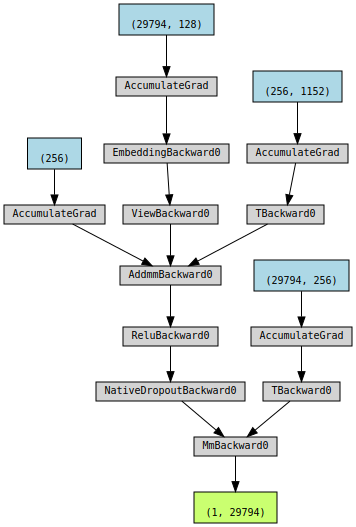

In [18]:
import torchviz

y = model(sample_train_gpu)

out = torchviz.make_dot(y)
out

In [19]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of model parameters: {num_params}')

Number of model parameters: 11736064


## Assert da Perplexidade


In [20]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)


def perplexity(logits, target):
    """
    Computes the perplexity.

    Args:
        logits: a FloatTensor of shape (batch_size, vocab_size)
        target: a LongTensor of shape (batch_size,)

    Returns:
        A float corresponding to the perplexity.
    """
    loss = F.cross_entropy(logits, target)
    return torch.exp(loss)


n_examples = 1000

sample_train, target_token_ids = next(iter(DataLoader(training_dataset, batch_size=n_examples)))
sample_train_gpu = sample_train.to(device)
target_token_ids = target_token_ids.to(device)
logits = model(sample_train_gpu)

my_perplexity = perplexity(logits=logits, target=target_token_ids)

print(f'my perplexity:              {int(my_perplexity)}')
print(f'correct initial perplexity: {tokenizer.vocab_size}')

assert math.isclose(my_perplexity, tokenizer.vocab_size, abs_tol=2000)
print('Passou o no assert da perplexidade')

my perplexity:              30672
correct initial perplexity: 29794
Passou o no assert da perplexidade


In [21]:
class SaveBestModel:

    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"Best validation loss: {self.best_valid_loss}")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/best_model.pth')

In [22]:
!mkdir outputs

## Laço de Treinamento e Validação

In [23]:
max_examples = 800_000_000
eval_every_steps = 5000
lr = 3e-5


model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    context_size=context_size,
    embedding_dim=128,
    hidden_size=512,
).to(device)

save_best_model = SaveBestModel()

train_loader = DataLoader(training_dataset, batch_size=1024, shuffle=True, drop_last=True)
validation_loader = DataLoader(valid_dataset, batch_size=1024)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


def train_step(input, target):
    model.train()
    model.zero_grad()

    logits = model(input.to(device))
    loss = nn.functional.cross_entropy(logits, target.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

last_loss = 30986.66 #Length vocab size adjust
patience = 2
trigger_times = 0


def validation_step(input, target):
    model.eval()
    logits = model(input)
    loss = nn.functional.cross_entropy(logits, target)
    return loss.item()


train_losses = []
n_examples = 0
step = 0

train_loss = []
valid_loss = []


while n_examples < max_examples:
    for input, target in train_loader:
        loss = train_step(input.to(device), target.to(device)) 
        train_losses.append(loss)
        
        if step % eval_every_steps == 0:
            train_ppl = np.exp(np.average(train_losses))

            with torch.no_grad():
                valid_ppl = np.exp(np.average([
                    validation_step(input.to(device), target.to(device))
                    for input, target in validation_loader]))

            print(f'{step} steps; {n_examples} examples so far; train ppl: {train_ppl:.2f}, valid ppl: {valid_ppl:.2f}')
            train_losses = []

        current_loss = valid_ppl

        train_loss.append(train_ppl)
        valid_loss.append(valid_ppl)

#----------------------Early stopping------------------------------------
        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break

        else:
            trigger_times = 0

        last_loss = current_loss

        save_best_model(
        last_loss, 0, model, optimizer, nn.functional.cross_entropy
        )
#------------------------------------------------------------------------        


        n_examples += len(input)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break

0 steps; 0 examples so far; train ppl: 30350.18, valid ppl: 30308.54
Best validation loss: 30308.536722044606
5000 steps; 5120000 examples so far; train ppl: 1931.23, valid ppl: 1285.79
Best validation loss: 1285.793127230622
10000 steps; 10240000 examples so far; train ppl: 1128.96, valid ppl: 954.71
Best validation loss: 954.7130947169651
15000 steps; 15360000 examples so far; train ppl: 880.49, valid ppl: 772.84
Best validation loss: 772.8367997076945
20000 steps; 20480000 examples so far; train ppl: 735.41, valid ppl: 659.50
Best validation loss: 659.496274964666
25000 steps; 25600000 examples so far; train ppl: 641.89, valid ppl: 579.39
Best validation loss: 579.3934090513076
30000 steps; 30720000 examples so far; train ppl: 566.88, valid ppl: 518.47
Best validation loss: 518.4669690055267
35000 steps; 35840000 examples so far; train ppl: 509.69, valid ppl: 470.96
Best validation loss: 470.96044912312414
40000 steps; 40960000 examples so far; train ppl: 467.52, valid ppl: 431.98
B

KeyboardInterrupt: ignored

## Avaliação final no dataset de teste


Bonus: o modelo com menor perplexidade no dataset de testes ganhará 0.5 ponto na nota final.

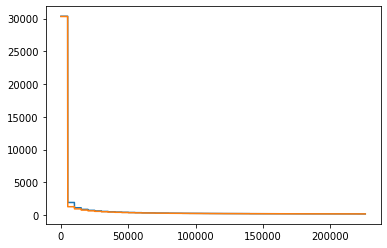

In [24]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(valid_loss)

#plot

In [25]:
test_loader = DataLoader(test_dataset, batch_size=64)

with torch.no_grad():
    test_ppl = np.exp(np.average([
        validation_step(input.to(device), target.to(device))
        for input, target in test_loader
    ]))

print(f'test perplexity: {test_ppl}')

test perplexity: 175.40090982627981


## Teste seu modelo com uma sentença

Escolha uma sentença gerada pelo modelo que ache interessante.

In [26]:
def tokenize(text: str, tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids

In [27]:
prompt = 'Eu gosto de comer pizza pois me faz'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor(input_ids_truncated).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Eu gosto de comer pizza pois me faz um
Eu gosto de comer pizza pois me faz um dia
Eu gosto de comer pizza pois me faz um dia de
Eu gosto de comer pizza pois me faz um dia de um
Eu gosto de comer pizza pois me faz um dia de um dia
Eu gosto de comer pizza pois me faz um dia de um dia,
Eu gosto de comer pizza pois me faz um dia de um dia, mas
Eu gosto de comer pizza pois me faz um dia de um dia, mas não
Eu gosto de comer pizza pois me faz um dia de um dia, mas não é
Eu gosto de comer pizza pois me faz um dia de um dia, mas não é que


In [37]:
max_examples = 600_000_000
eval_every_steps = 5000
lr = 3e-5


model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    context_size=context_size,
    embedding_dim=128,
    hidden_size=512,
).to(device)
load_dict = torch.load("outputs/best_model.pth")
model.load_state_dict(load_dict['model_state_dict'])
model.to(device)

train_loader = DataLoader(training_dataset, batch_size=1024, shuffle=True, drop_last=True)
validation_loader = DataLoader(valid_dataset, batch_size=1024)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


def train_step(input, target):
    model.train()
    model.zero_grad()

    logits = model(input.to(device))
    loss = nn.functional.cross_entropy(logits, target.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

last_loss = 30986.66 #Length vocab size adjust
patience = 2
trigger_times = 0


def validation_step(input, target):
    model.eval()
    logits = model(input)
    loss = nn.functional.cross_entropy(logits, target)
    return loss.item()


train_losses = []
n_examples = 0
step = 0

train_loss = []
valid_loss = []


while n_examples < max_examples:
    for input, target in train_loader:
        loss = train_step(input.to(device), target.to(device)) 
        train_losses.append(loss)
        
        if step % eval_every_steps == 0:
            train_ppl = np.exp(np.average(train_losses))

            with torch.no_grad():
                valid_ppl = np.exp(np.average([
                    validation_step(input.to(device), target.to(device))
                    for input, target in validation_loader]))

            print(f'{step} steps; {n_examples} examples so far; train ppl: {train_ppl:.2f}, valid ppl: {valid_ppl:.2f}')
            train_losses = []

        current_loss = valid_ppl

        train_loss.append(train_ppl)
        valid_loss.append(valid_ppl)

#----------------------Early stopping------------------------------------
        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break

        else:
            trigger_times = 0

        last_loss = current_loss

        save_best_model(
        last_loss, 0, model, optimizer, nn.functional.cross_entropy
        )
#------------------------------------------------------------------------        


        n_examples += len(input)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break

0 steps; 0 examples so far; train ppl: 188.14, valid ppl: 189.13
5000 steps; 5120000 examples so far; train ppl: 190.79, valid ppl: 194.67
Trigger Times: 1
10000 steps; 10240000 examples so far; train ppl: 189.34, valid ppl: 191.38
15000 steps; 15360000 examples so far; train ppl: 187.94, valid ppl: 189.14
20000 steps; 20480000 examples so far; train ppl: 187.21, valid ppl: 187.62
Best validation loss: 187.61769248393577
25000 steps; 25600000 examples so far; train ppl: 185.89, valid ppl: 185.88
Best validation loss: 185.8789640980991
30000 steps; 30720000 examples so far; train ppl: 181.41, valid ppl: 184.70
Best validation loss: 184.70388165817033
35000 steps; 35840000 examples so far; train ppl: 180.01, valid ppl: 183.77
Best validation loss: 183.7693814008897
40000 steps; 40960000 examples so far; train ppl: 179.42, valid ppl: 182.44
Best validation loss: 182.44200192969407
45000 steps; 46080000 examples so far; train ppl: 179.09, valid ppl: 181.63
Best validation loss: 181.6281915

KeyboardInterrupt: ignored

In [38]:
test_loader = DataLoader(test_dataset, batch_size=64)

with torch.no_grad():
    test_ppl = np.exp(np.average([
        validation_step(input.to(device), target.to(device))
        for input, target in test_loader
    ]))

print(f'test perplexity: {test_ppl}')

test perplexity: 141.27687212150423


In [39]:
def tokenize(text: str, tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids

In [40]:
prompt = 'Eu gosto de comer pizza pois me faz'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor(input_ids_truncated).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Eu gosto de comer pizza pois me faz.
Eu gosto de comer pizza pois me faz..
Eu gosto de comer pizza pois me faz...
Eu gosto de comer pizza pois me faz....
Eu gosto de comer pizza pois me faz.....
Eu gosto de comer pizza pois me faz......
Eu gosto de comer pizza pois me faz.......
Eu gosto de comer pizza pois me faz........
Eu gosto de comer pizza pois me faz.........
Eu gosto de comer pizza pois me faz..........
